Root Mean Squared Error (RMSE): 25303.78


C:\Users\Sriram\AppData\Local\Temp\ipykernel_25916\3155037563.py:17: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\Sriram\AppData\Local\Temp\ipykernel_25916\3155037563.py:58: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



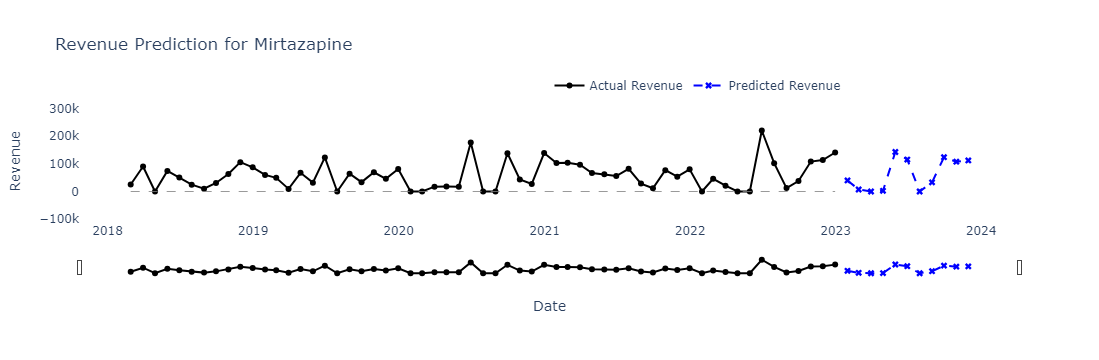

In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df = pd.read_csv('medicinal_sales_tamil_nadu_100002.csv', parse_dates=['Date'])

df['Revenue'] = pd.to_numeric(df['Revenue'], errors='coerce')
df['Quantity Sold'] = pd.to_numeric(df['Quantity Sold'], errors='coerce')
df['Product Price'] = pd.to_numeric(df['Product Price'], errors='coerce')

product_name = 'Mirtazapine'
df_product = df[df['Product Name'] == product_name]

df_product = df_product.resample('M', on='Date').sum()

df_product['Month'] = df_product.index.month
df_product['Quarter'] = df_product.index.quarter
df_product['Year'] = df_product.index.year
df_product['Day_of_Week'] = df_product.index.dayofweek

features = ['Quantity Sold', 'Product Price', 'Month', 'Quarter', 'Year', 'Day_of_Week']
X = df_product[features]
y = df_product['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model = XGBRegressor(
    objective='reg:squarederror',
    alpha=0.5,
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.2,
    max_depth=3,
    min_child_weight=10,
    n_estimators=200,
    subsample=0.8,
    random_state=42,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = np.maximum(0, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

end_date_actual = '2022-12-31'

df_actual_up_to_2022 = df_product[df_product.index <= end_date_actual]

start_date_predicted = df_product.index[-len(y_pred):].max()
df_predicted = X_test.copy()
df_predicted['Predicted Revenue'] = y_pred
df_predicted.index = pd.date_range(start=start_date_predicted, periods=len(y_pred), freq='M')
df_predicted = df_predicted.loc[df_predicted.index > end_date_actual]

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_actual_up_to_2022.index,
                         y=df_actual_up_to_2022['Revenue'],
                         mode='lines+markers',
                         name='Actual Revenue',
                         line=dict(color='black'),
                         marker=dict(symbol='circle')))

fig.add_trace(go.Scatter(x=df_predicted.index,
                         y=df_predicted['Predicted Revenue'],
                         mode='lines+markers',
                         name='Predicted Revenue',
                         line=dict(color='blue', dash='dash'),
                         marker=dict(symbol='x')))

fig.update_layout(
    title=f'Revenue Prediction for {product_name}',
    xaxis_title='Date',
    yaxis_title='Revenue',
    yaxis=dict(range=[-df_product['Revenue'].max() * 0.5, df_product['Revenue'].max() * 1.5]),
    xaxis_rangeslider_visible=True,
    legend=dict(x=0.5, y=1, traceorder='normal', orientation='h'),
    plot_bgcolor='white'
)

fig.add_shape(
    type="line",
    x0=df_product.index.min(),
    y0=0,
    x1=df_product.index.max(),
    y1=0,
    line=dict(color="gray", width=0.8, dash="dash")
)

fig.show()


### 

In [ ]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objects as go

df = pd.read_csv('medicinal_sales_tamil_nadu_100002.csv')
df['Date'] = pd.to_datetime(df['Date'])

product_name = 'Paracetamol'
product_data = df[df['Product Name'] == product_name]
product_data = product_data.groupby('Date').agg({'Quantity Sold': 'sum'}).reset_index()
product_data.columns = ['ds', 'y']

print(product_data.head())

if product_data.dropna().shape[0] < 2:
    print("Insufficient data for forecasting.")
else:
    product_data = product_data.fillna(method='ffill')
    model = Prophet()
    model.fit(product_data)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=product_data['ds'], y=product_data['y'], mode='lines', name='Actual Sales', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', name='Lower Confidence Interval', line=dict(dash='dash', color='gray')))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', name='Upper Confidence Interval', line=dict(dash='dash', color='gray')))
    
    fig.update_layout(title=f'Seasonal Sales Forecast for {product_name}', xaxis_title='Date', yaxis_title='Quantity Sold')
    fig.show()
